과적합과 드롭아웃

- 학습성능은 좋지만, 테스트 셋 or 실제상황에서는 성능이 나오지 않을 때는 과적합이라 한다. 

  ( 학습 데이터에 너무 치중되어 유연성 부족한 이유 )
  
- 학습을 제대로 진행하지 않은 상태는 과소적합이라 한다. 
- 우리가 원하는 상태는 과소적합과 과적합의 중간이다. 이렇게 모든 데이터에서 높은 성능을 내는 상태를 일반화라고 한다.
- 데이터 셋을 학습, 검증, 테스트셋으로 나누는 이유도 과적합을 탐지하려는 노력의 일환이다.
- 검증 데이터셋에 대한 성능이 나빠지기 시작하기 직전이 가장 적합한 모델이라고 할 수 있다. 

  ( 이 타이밍에 모델을 저장하여 이용하는 것을 조기 종료라고 한다. )
- 과적합은 학습 데이터를 늘리는 방법과 방지 기능을 하는 드롭아웃을 모델 구조에 적용하는 방법이 있다. 

    1) 데이터 늘리기 
    - 데이터를 추가적으로 수집하기에는 한계가 있어 이미 가진 데이터를 최대한 늘리는 방법을 많이 이용한다.
    - 이미지 데이터의 경우 일부를 자르거나, 돌리고, 노이즈를 더하고, 색상 변경 등 여러 방법이 있다. 
    - 앞선 예제의 경우 가로 대칭이동전략을 이용
    - 데이터를 직접 조작은 귀찮지만, 토치비전의 transforms 패키지를 이용하면 간단하게 조작 할 수 있다.
    

In [5]:
from torchvision import datasets, transforms, utils
from torch.utils import data
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn #인공싱경망 재료
import torch.optim as optim #최적화
import torch.nn.functional as F #nn모듈의 함수버전

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")


EPOCHS = 50
BATCH_SIZE = 64

train_loader = torch.utils.data.DataLoader(datasets.FashionMNIST('./.data',
                                                         train=True,
                                                         download=True,
                                                         transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                                                                        transforms.ToTensor(),
                                                                                        transforms.Normalize((0.1307,),(0.3081,))])),
                                          batch_size= BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(datasets.FashionMNIST('./.data',
                                                         train=False,
                                                         download=True,
                                                         transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                                                                        transforms.ToTensor(),
                                                                                        transforms.Normalize((0.1307,),(0.3081,))])),
                                          batch_size= BATCH_SIZE, shuffle = True)

- transforms.compose() 함수를 호출하며 이용한 RandomHorizontalFlip은 이미지를 무작위로 수평 뒤집기를 한다. 

  ( 이미지를 뒤집는 것만으로 예제의 수가 2배로 늘었다. )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


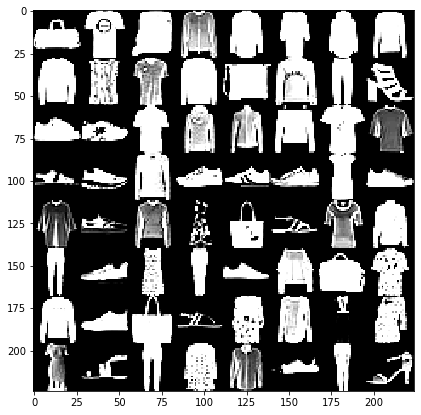

In [4]:
#데이터 확인
dataiter = iter(train_loader)
images, labels = next(dataiter)

img = utils.make_grid(images, padding =  0) # 여러 이미지를 모아 하나의 이미지로 만들기
npimg = img.numpy() #텐서를 넘파이 행렬로 바꿔 matplotlib과 호환되게 변환
plt.figure(figsize=(10,7))
plt.imshow(np.transpose(npimg, (1,2,0))) #인식 차원의 순서가 달라 0번째 차원을 맨뒤로 보낸다. 
plt.show()

드롭 아웃
- 데이터도 중요하지만 모델에 직접 영향을 주어 과적합을 해결하는 좋은 방법
- 학습 진행과정에서 신경망의 일부를 사용하지 않는 방법이다. 
- 50% 드롭아웃이면 학습 단계마다 절반의 뉴런만 이용한다. ( 검증과 테스트에서는 모두 이용 )
- 학습에서 배재된 뉴런 외에 다른 뉴런들에게 가중치를 분산시키고 개별 뉴런이 특징에 고정되는 현상을 방지하는 기능 
- 모델 클래스 생성자에 드롭아웃 비율을 결정하는 dropout_p 파라미터 추가로 구현 가능

In [6]:
class Net(nn.Module):
    #드롭아웃 확률 20%로 설정
    def __init__(self, dropout_p = 0.2):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784,256)
        self.fc2 = nn.Linear(256,128) 
        self.fc3 = nn.Linear(128,10)
        #드롭아웃 확률
        self.dropout_p = dropout_p
    
    #또한 forward에 F.dropout()만 추가하면 구현이 완성 
    #F.dropout()은 가중치가 없어 torch.nn.functional에서 바로 가져와 이용 가능하고,
    #취향에 따라 nn.Dropout 클래스 이용도 무방하다. (F.dropout()을 쓰며 self.training등 몇가지 내부 변수를 자동으로 적용하는 모듈)
    def forward(self, x): 
        x = x.view(-1, 784)       #입력을 받아 view함수를 이용하여 1차원 행렬 변환 후 Relu 활성화 함수 거친다.
        x = F.relu(self.fc1(x))   #nn.Linear와 같이 가중치가 있는 연산은 생성자에 선언해주는 것이 좋다. 
        #드롭아웃 추가
        x = F.dropout(x, training = self.training, p = self.dropout_p)
        x = F.relu(self.fc2(x))
        #드롭아웃 추가
        x = F.dropout(x, training = self.training, p = self.dropout_p)
        x = self.fc3(x)
        return x

In [7]:
#모델 인스턴스화 할때 드롭아웃 확률 추가 

model = Net(dropout_p = 0.2).to(DEVICE)

In [8]:
optimizer = optim.SGD(model.parameters(), lr = 0.01)

In [9]:
#학습은 데이터를 보고 모델의 가중치 조절 작업 반복
#학습에 들어가는 모든 연산은 train()에서 해결 
def train(model, train_loader, optimizer):
    model.train()#학습모드 변경
    for batch_idx, (data, target) in enumerate(train_loader):  #모델 입력 data오양 [ 배치크기, 색, 높이, 넓이 ] 
        # 학습 데이터를 DEVICE의 메모리로 보냄
        data, target = data.to(DEVICE), target.to(DEVICE) # 학습 데이터를 DEVICE의 메모리로 보냄
        optimizer.zero_grad() #기울기 계산
        output = model(data)#학습 데이터에 대한 모델 예측값
        loss = F.cross_entropy(output, target)# 오차함수, 가중치 보관이 필요없어 criterion함수 미생성
        loss.backward()
        optimizer.step()
        
#epoch가 끝날 때마다 테스트 셋 모델 성능 측정
def evaluate(model, test_loader):
    model.eval() #평가모드로 전환
    test_loss = 0
    correct = 0#테스트 오차와 예측이 맞은 변수를 0으로 초기화 
    with torch.no_grad(): #평가 과정은 기울기 계산 필요 없음.
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            # 모든 오차 더하기
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item() #reduction = 'sum'지정으로 미니배치 평균이 아닌 합을 받아온다. 
            
            # 가장 큰 값을 가진 클래스가 모델의 예측입니다.
            # 예측과 정답을 비교하여 일치할 경우 correct에 1을 더합니다.
            pred = output.max(1, keepdim=True)[1]#가장 큰값과, 인덱스 출력
            correct += pred.eq(target.view_as(pred)).sum().item()#각 배치마다 정답 맞힌 개수 합

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)#테스트 셋 데이터 수로 나눠 평균을 구하여 오차와 맞힌 개수를 100에 곱하여 정확도 구하기 
    return test_loss, test_accuracy        

In [10]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print('[{}] TEST Loss : {}, Accuracy : {}%'.format(epoch, test_loss, test_accuracy))

[1] TEST Loss : 0.6380362361907959, Accuracy : 77.43%
[2] TEST Loss : 0.5327263809204101, Accuracy : 80.67%
[3] TEST Loss : 0.4922250398635864, Accuracy : 82.06%
[4] TEST Loss : 0.45857717332839965, Accuracy : 83.32%
[5] TEST Loss : 0.4450070328712463, Accuracy : 83.85%
[6] TEST Loss : 0.4232404476642609, Accuracy : 84.57%
[7] TEST Loss : 0.4227541977405548, Accuracy : 84.56%
[8] TEST Loss : 0.41401360173225404, Accuracy : 84.79%
[9] TEST Loss : 0.39815378427505493, Accuracy : 85.76%
[10] TEST Loss : 0.38977997438907624, Accuracy : 85.99%
[11] TEST Loss : 0.3887642081260681, Accuracy : 85.9%
[12] TEST Loss : 0.37749987211227415, Accuracy : 86.45%
[13] TEST Loss : 0.3767843789815903, Accuracy : 86.31%
[14] TEST Loss : 0.38684851770401, Accuracy : 85.71%
[15] TEST Loss : 0.3691597609519959, Accuracy : 86.7%
[16] TEST Loss : 0.3622957499265671, Accuracy : 87.03%
[17] TEST Loss : 0.35754226113557813, Accuracy : 87.09%
[18] TEST Loss : 0.35732347350120547, Accuracy : 87.0%
[19] TEST Loss : 

- 데이터셋에 노이즈를 추가하거나 모델에 드롭아웃을 적용할 때 최고성능에 도달할 때 까지 걸리는 시간은 길어진다. 
- 데이터셋이 늘고, 모델이 느리게 학습되기 때문이다. 
- epoch를 늘려 학습 진행하였는데 정확도가 눈에 띄게 높이 시작했다.